<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Augmentation/Analysis" data-toc-modified-id="Data-Augmentation/Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation/Analysis</a></span></li><li><span><a href="#Dataloader-creation-and-test" data-toc-modified-id="Dataloader-creation-and-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataloader creation and test</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model creation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Model-Testing" data-toc-modified-id="Model-Testing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Testing</a></span></li></ul></li></ul></div>

**GET DATA**

Summary of this notebook: ...

Definition of Done: ...

# Imports


In [2]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from pprint import pprint

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import PReLU


# Check to see if GPU is being used
print(tensorflow.test.gpu_device_name())
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


# Dataloader creation and test

In [22]:
# NEW MODIS DATASET

# img_paths = glob.glob("/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*")
# img_paths = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*") # <- needs to be normalized
img_paths = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*") # <- needs to be normalized
img_paths = sorted(img_paths)
print("len(img_paths):", len(img_paths))
# random.shuffle(img_paths)

train_test_split = 0.8
X_train_paths = img_paths[:int(train_test_split*len(img_paths))]
X_test_paths = img_paths[int(train_test_split*len(img_paths)):]

# np.save(PATH_LIST_LOCATION, [X_train_paths, X_test_paths])

dims=(448,448,3)

# Loading Training Data
X_train = np.empty((len(X_train_paths),*dims))
for i, p in enumerate(X_train_paths):
    X_train[i,:,:,:] = np.load(p)

# Loading Testing Data
X_test = np.empty((len(X_test_paths),*dims))
for i, p in enumerate(X_test_paths):
    X_test[i,:,:,:] = np.load(p)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# To check what percentage of pixels are 'nan'
print(np.sum(np.isnan(X_train)) / np.prod(X_train.shape))
print(np.sum(np.isnan(X_test)) / np.prod(X_test.shape))

# Checking min max to see if normalization is needed or not
print("Before normalization")
print(np.nanmin(X_train), np.nanmax(X_train))
print(np.nanmin(X_test), np.nanmax(X_test))

# Normalize Inputs
def normalize(mat):
    valid_cells = np.invert(np.isnan(mat))
    normalized = np.subtract(mat, np.nanmin(mat), where=valid_cells) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

# Checking min max after normalization 
print("After normalization")
print(np.nanmin(X_train), np.nanmax(X_train))
print(np.nanmin(X_test), np.nanmax(X_test))

# Set nan values to 0
# X_train[np.isnan(X_train)] = 0.0
# X_test[np.isnan(X_test)] = 0.0

len(img_paths): 365
X_train: (292, 448, 448, 3)
X_test: (73, 448, 448, 3)
0.10412283692907814
0.10421119030874336
Before normalization
-0.37667901924167624 0.9248779007187233
-0.38055410601879036 0.9133554307612648
After normalization
0.0 1.0
0.0 1.0


In [23]:
# NEW MODIS DATASET

img_paths_orig = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_normalized/448/*")
img_paths_orig = sorted(img_paths_orig)
# img_paths_orig = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*") # <- needs to be normalized
# img_paths_orig = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*") # <- needs to be normalized
print("len(img_paths_orig):", len(img_paths_orig))
# random.shuffle(img_paths_orig)

train_test_split = 0.8
X_train_paths_orig = img_paths_orig[:int(train_test_split*len(img_paths_orig))]
X_test_paths_orig = img_paths_orig[int(train_test_split*len(img_paths_orig)):]

# np.save(PATH_LIST_LOCATION, [X_train_paths_orig, X_test_paths_orig])

dims=(448,448,3)

# Loading Training Data
X_train_orig = np.empty((len(X_train_paths_orig),*dims))
for i, p in enumerate(X_train_paths_orig):
    X_train_orig[i,:,:,:] = np.load(p)

# Loading Testing Data
X_test_orig = np.empty((len(X_test_paths_orig),*dims))
for i, p in enumerate(X_test_paths_orig):
    X_test_orig[i,:,:,:] = np.load(p)

print("X_train_orig:", X_train_orig.shape)
print("X_test_orig:", X_test_orig.shape)

# To check what percentage of pixels are 'nan'
print(np.sum(np.isnan(X_train_orig)) / np.prod(X_train_orig.shape))
print(np.sum(np.isnan(X_test_orig)) / np.prod(X_test.shape))

# Checking min max to see if normalization is needed or not
print("Before normalization")
print(np.nanmin(X_train_orig), np.nanmax(X_train_orig))
print(np.nanmin(X_test_orig), np.nanmax(X_test_orig))

# Normalize Inputs
def normalize(mat):
    valid_cells = np.invert(np.isnan(mat))
    normalized = np.subtract(mat, np.nanmin(mat), where=valid_cells) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized

X_train_orig = normalize(X_train_orig)
X_test_orig = normalize(X_test_orig)

# Checking min max after normalization 
print("After normalization")
print(np.nanmin(X_train_orig), np.nanmax(X_train_orig))
print(np.nanmin(X_test_orig), np.nanmax(X_test_orig))

# Set nan values to 0
# X_train[np.isnan(X_train)] = 0.0
# X_test[np.isnan(X_test)] = 0.0

len(img_paths_orig): 365
X_train_orig: (292, 448, 448, 3)
X_test_orig: (73, 448, 448, 3)
0.10412283692907814
0.10421119030874336
Before normalization
0.0 1.0
0.0 1.0
After normalization
0.0 1.0
0.0 1.0


(292, 448, 448, 3)
(292, 448, 448, 3)


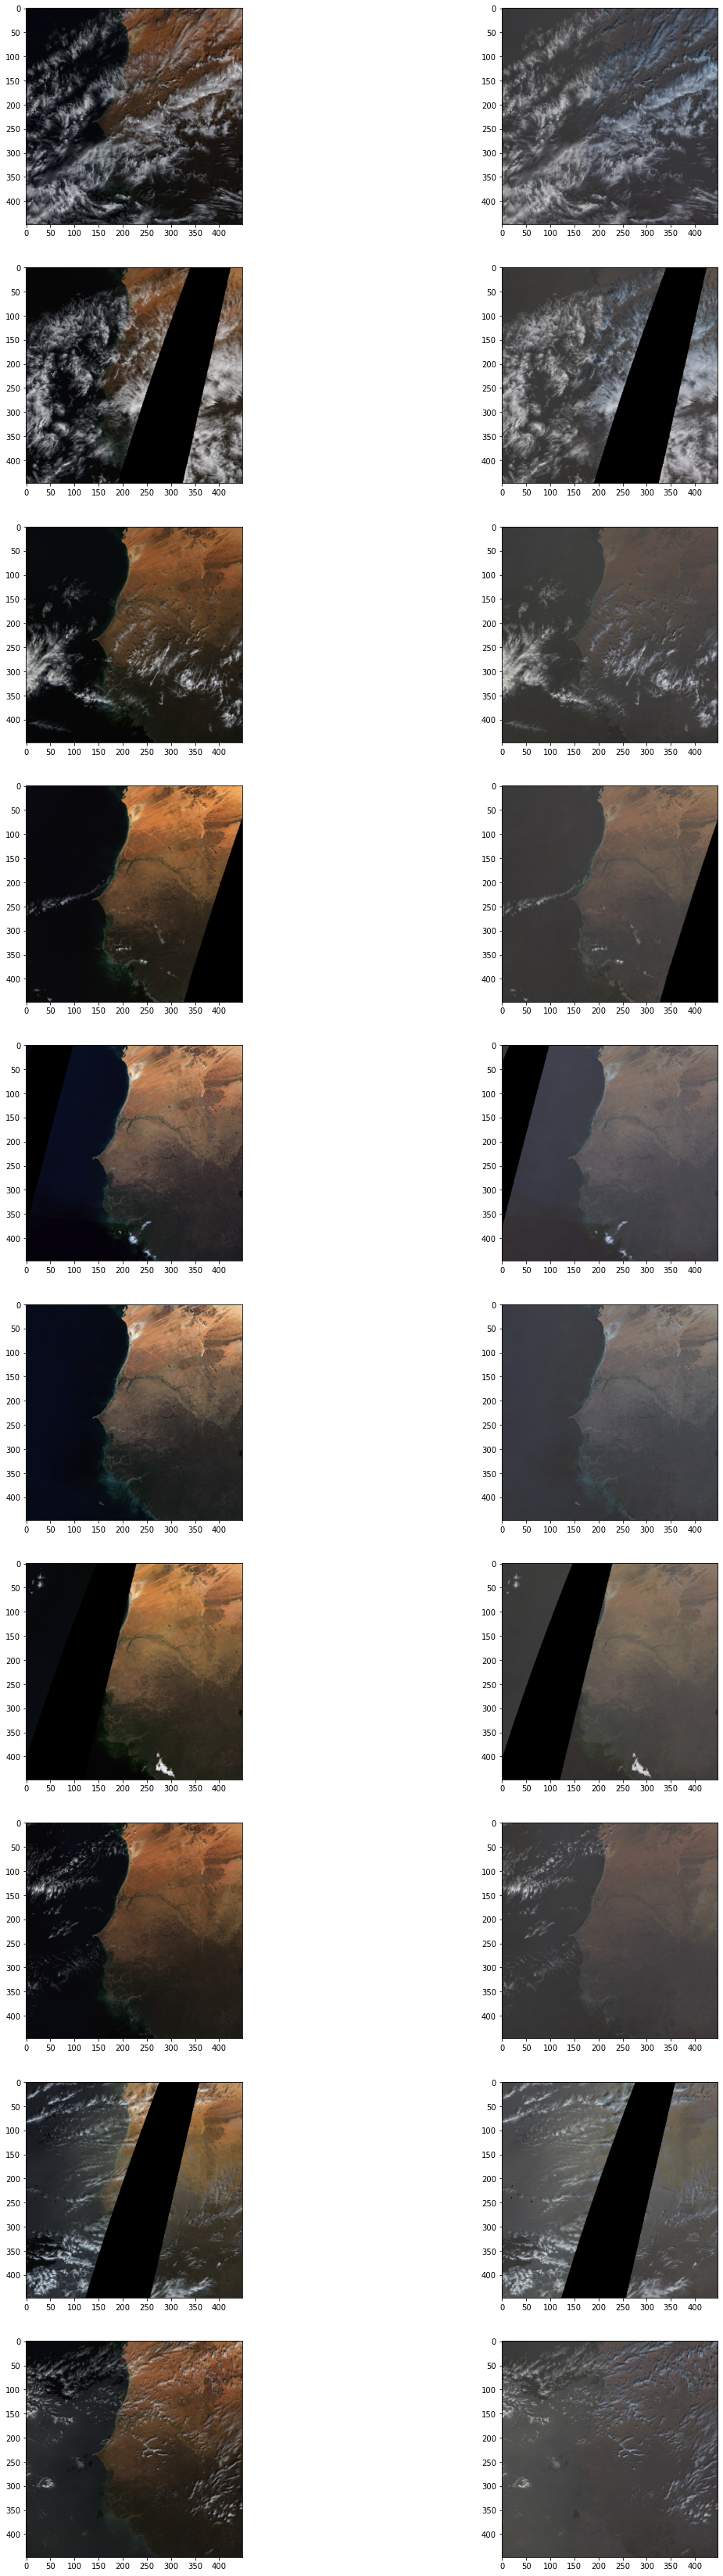

In [34]:
print(X_train.shape)
print(X_train_orig.shape)
r = 10
c = 2
fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(20,60))
for i in range(r):
    axs[i, 0].imshow(X_train_orig[10+i,:,:,:])
    axs[i, 1].imshow(X_train[10+i,:,:,:])

fig.savefig("orig_vs_median.png")